In [369]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jayaprakashpondy/pancreatic-ct-images")

print("Path to dataset files:", path)

Path to dataset files: /Users/shafayat/.cache/kagglehub/datasets/jayaprakashpondy/pancreatic-ct-images/versions/1


In [370]:
path = path + "/DATASET"
path

'/Users/shafayat/.cache/kagglehub/datasets/jayaprakashpondy/pancreatic-ct-images/versions/1/DATASET'

In [371]:
import torch
import torchvision
from torchvision import datasets, transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet expects 224x224 input size
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

train_data = datasets.ImageFolder(path+"/train/train", transform=train_transforms)
test_data = datasets.ImageFolder(path+"/test/test", transform=test_transforms)

In [372]:
train_data

Dataset ImageFolder
    Number of datapoints: 999
    Root location: /Users/shafayat/.cache/kagglehub/datasets/jayaprakashpondy/pancreatic-ct-images/versions/1/DATASET/train/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [373]:
test_data

Dataset ImageFolder
    Number of datapoints: 412
    Root location: /Users/shafayat/.cache/kagglehub/datasets/jayaprakashpondy/pancreatic-ct-images/versions/1/DATASET/test/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [374]:
train_data.classes

['normal', 'pancreatic_tumor']

In [375]:
train_data.class_to_idx

{'normal': 0, 'pancreatic_tumor': 1}

In [376]:
train_data[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [377]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

len(train_loader), len(test_loader)

(32, 13)

In [378]:
next(iter(train_loader))[0][0].shape

torch.Size([3, 224, 224])

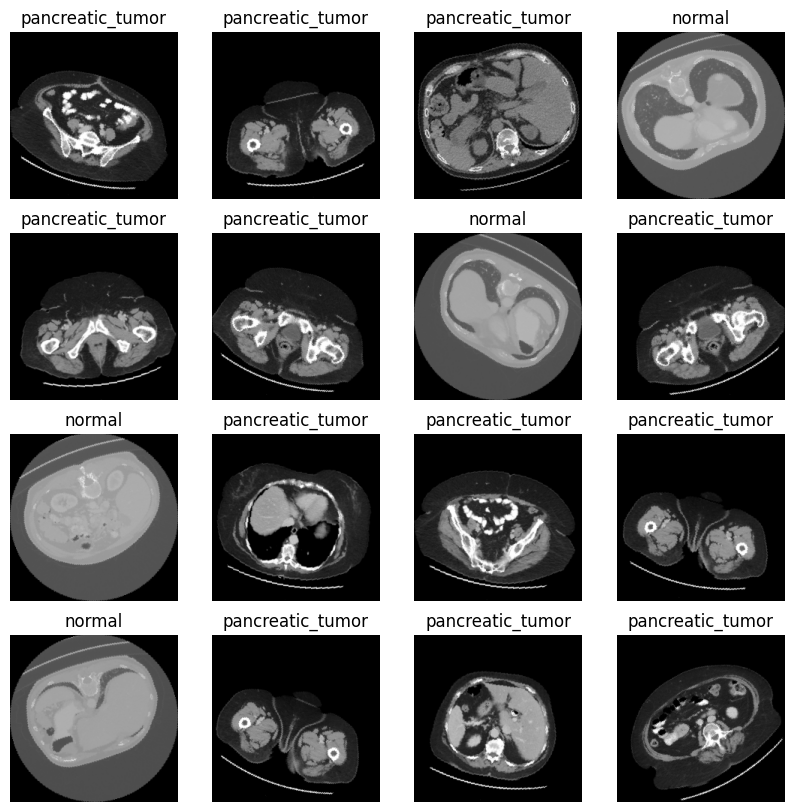

In [379]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))

for i in range(16):
    figure.add_subplot(4,4,i+1)
    image, label = train_data[torch.randint(0, len(train_data),size=[1])]
    plt.imshow(image.permute(1,2,0))
    plt.axis(False)
    plt.title(train_data.classes[label])

In [380]:
from torch import nn


In [381]:
class ModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, padding=1, stride=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, padding=1, stride=2, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, stride=2, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=90, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # print(x.shape)
        # layer = nn.Flatten()
        # print(layer(x).shape)
        x = self.classifier(x)
        return x

In [382]:
model = ModelV0()
model

ModelV0(
  (conv1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=90, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [383]:
batch = next(iter(train_loader))
image = batch[0][0]

In [384]:
image, _ = train_data[0]

In [385]:
y = model(image.unsqueeze(0))

In [386]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [387]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [388]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm.auto import tqdm

In [389]:
test_loss_val = []
train_loss_val = []
test_acc_val = []
train_acc_val = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in tqdm(train_loader):
        y_logits = model(X)
        y_prob = torch.sigmoid(y_logits.squeeze())
        y_pred = torch.round(y_prob)
        # print(y_logits.shape)
        # print(y_logits.dtype)
        # print(y.shape)
        # print(y.dtype)

        loss = loss_fn(y_logits.squeeze(), y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_score(y.detach().cpu().numpy(), y_pred.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    print(f'Epoch: {epoch} train loss: {train_loss} train acc: {train_acc}')

    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.inference_mode():
        for X,y in tqdm(test_loader):
            y_logits = model(X)
            y_prob = torch.sigmoid(y_logits.squeeze())
            y_pred = torch.round(y_prob)

            loss = loss_fn(y_logits.squeeze(), y.float())
            test_loss += loss.item()
            test_acc += accuracy_score(y.squeeze(), y_pred)

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

    print(f'Epoch: {epoch} test loss: {test_loss} test acc: {test_acc}')

    train_acc_val.append(test_acc)
    train_loss_val.append(train_loss)
    test_acc_val.append(test_acc)
    test_loss_val.append(test_loss)

    

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 train loss: 0.6841309648007154 train acc: 0.47335379464285715


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 0 test loss: 0.7565860610741836 test acc: 0.45295329670329665


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 train loss: 0.37262400425970554 train acc: 0.8447265625


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 1 test loss: 1.8395531452619112 test acc: 0.46565934065934067


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 train loss: 0.2448852793313563 train acc: 0.96484375


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 2 test loss: 0.2817736749465649 test acc: 0.9831730769230769


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 train loss: 0.19824578147381544 train acc: 0.9716796875


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 3 test loss: 0.7141289367125585 test acc: 0.553228021978022


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 train loss: 0.17936683353036642 train acc: 0.966796875


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 4 test loss: 0.18599728437570426 test acc: 0.9903846153846154


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 train loss: 0.1661058112513274 train acc: 0.9658203125


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 5 test loss: 0.13493534922599792 test acc: 1.0


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 train loss: 0.15475255314959213 train acc: 0.96484375


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 6 test loss: 0.19086968440275925 test acc: 0.9831730769230769


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 train loss: 0.13661662093363702 train acc: 0.9697265625


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 7 test loss: 0.166174061023272 test acc: 0.9876373626373626


  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 